# Example usage

Here we will demonstrate how to use `SeisScan` to detect and locate earthquakes.

We will first read data from IRIS full wavefield experiment.

We will then proceed to compute characteristic function and backproject them for detection and location.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import glob
from obspy import UTCDateTime, Stream
from obspy.geodetics import gps2dist_azimuth
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from dask.distributed import Client as dask_Client

import seisscan as ss
print(ss.__version__)

0.1.0


## Start DASK for parallel processing

In [2]:
n_workers = os.cpu_count() - 2
dask_client = dask_Client(n_workers=n_workers)

## Read example data

In [3]:
event_dict, st, inventory, subnetworks, model_name = ss.read_example()

Let's extract event information

In [4]:
evt0 = UTCDateTime(event_dict["evt0"])    # event origin time
evlo = event_dict["evlo"]                 # event longitude
evla = event_dict["evla"]                 # event latitude
evdp = event_dict["evdp"]                 # event depth (km)
mag = event_dict["mag"]                   # event magnitude

Print the `Subnetworks`

In [5]:
subnetworks

[{'reference': '1002', 'secondaries': ['1001', '1003']},
 {'reference': '1041', 'secondaries': ['5019', '5020', '5025', '5026']},
 {'reference': '1073', 'secondaries': ['5004', '5005', '5012', '5013']},
 {'reference': '1128', 'secondaries': ['1127', '1129']},
 {'reference': '2005', 'secondaries': ['2004', '2006']},
 {'reference': '2048', 'secondaries': ['2047', '2049']},
 {'reference': '3002', 'secondaries': ['3001', '3003']},
 {'reference': '3048', 'secondaries': ['3047', '3049']}]

Plot a record section of the stream

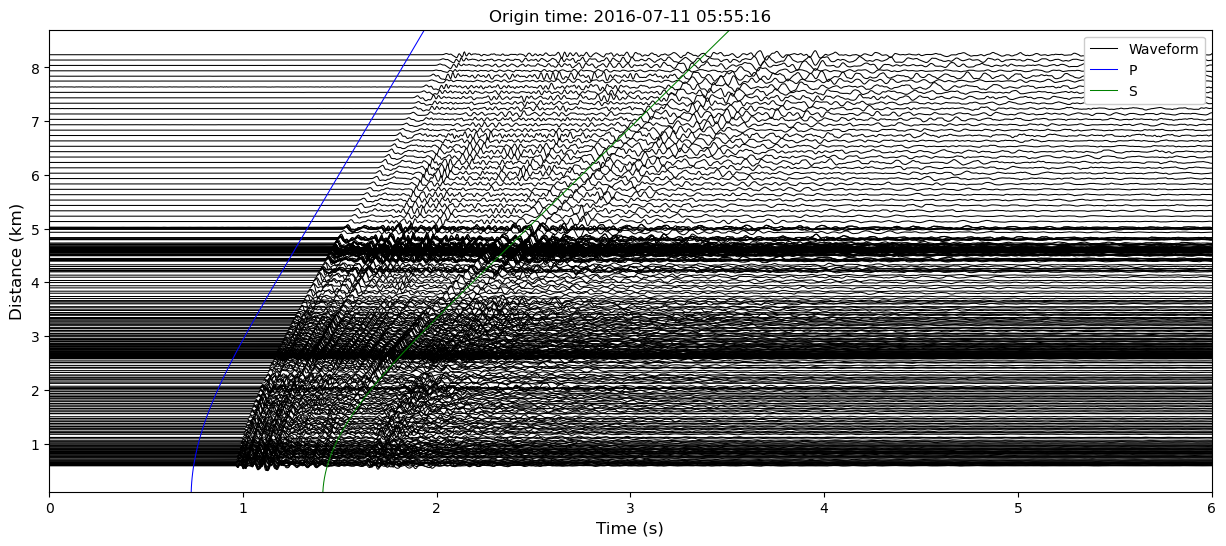

In [6]:
channel = "DPZ"

fig = ss.prs(st.select(channel=channel),
             evt0, evlo, evla, evdp, scale=0.1, model_name=model_name,
             xmin=0.0, xmax=6.0, width=15, height=6, handle=True)

## Select Stream for the stations in the ``Subnetworks``

In [7]:
st_sel = Stream()

for subnetwork in subnetworks:
    reference = subnetwork["reference"]
    secondaries = subnetwork["secondaries"]
    
    st_sel += st.select(station=reference)
    
    for secondary in secondaries:
        st_sel += st.select(station=secondary)
        

Plot a record section of the selected stream

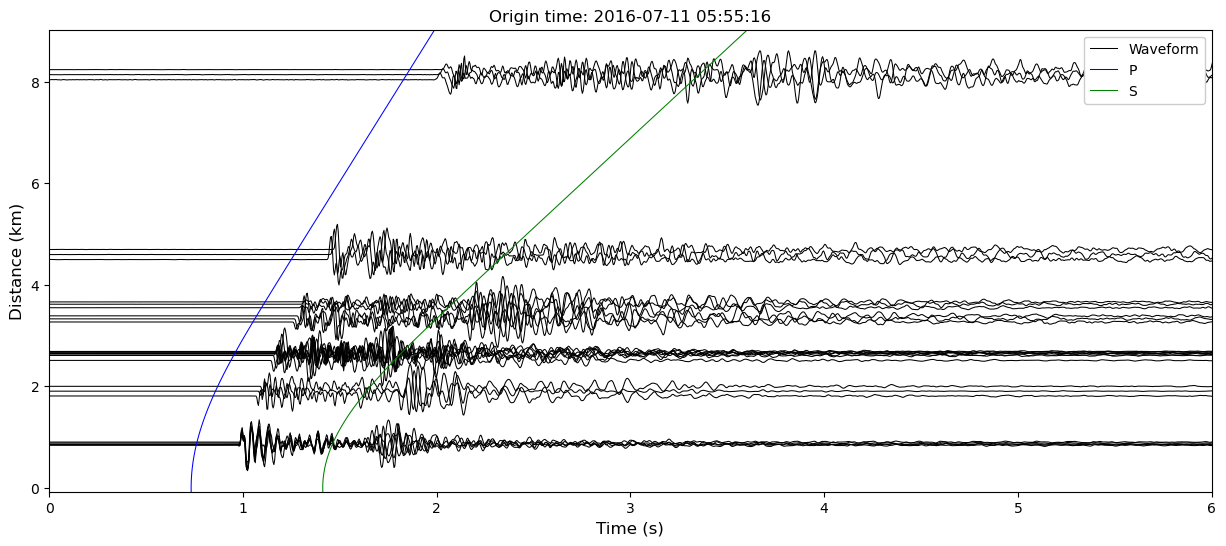

In [8]:
channel = "DPZ"

fig = ss.prs(st_sel.select(channel=channel),
             evt0, evlo, evla, evdp, scale=0.5, model_name=model_name,
             xmin=0.0, xmax=6.0, width=15, height=6, handle=True)



## Pre-process the selected stream

In [9]:
#--- take a copy of the selected stream
st_proc = st_sel.copy()

#--- detrend the data
st_proc.detrend(type='linear');

#--- remove instrument response
pre_filt = [0.1, 0.2, 200.0, 250.0]   # Hz
st_proc.remove_response(output='VEL', pre_filt=pre_filt);

#--- rotation from 'Z12' to 'ZNE
st_proc.rotate('->ZNE', inventory=inventory);

#--- filter
f1, f2 = 25.0, 75.0
st_proc.select(component='Z').filter('bandpass', freqmin=f1, freqmax=f2);

f1, f2 = 10.0, 30.0
st_proc.select(component='N').filter('bandpass', freqmin=f1, freqmax=f2);
st_proc.select(component='E').filter('bandpass', freqmin=f1, freqmax=f2);

#--- Merge traces with similar seed_id
st_proc.merge(method=1, fill_value=0);

#--- Trim the stream so that every trace has similar starttime and endtime
starttime = min([tr.stats.starttime for tr in st_proc])
endtime = max([tr.stats.endtime for tr in st_proc])
st_proc.trim(starttime, endtime, pad=True, fill_value=0);


## Compute characteristic function (Local Similarity)

In [10]:
channels = ['DPZ', 'DPN', 'DPE']
w = 0.75 # window length in seconds
dt = 0.05 # stride in seconds
max_lag = 0.1 # maximum lag in seconds

st_r = Stream()
st_dls = Stream()

for channel in channels:
    _, _, _, _, _, st_dls_ = ss.do_ls(st_proc, channel, subnetworks=subnetworks, w=w, dt=dt, max_lag=max_lag, dask_client=dask_client)
    st_dls += st_dls_
    

Plot a record section of the characteristic functions

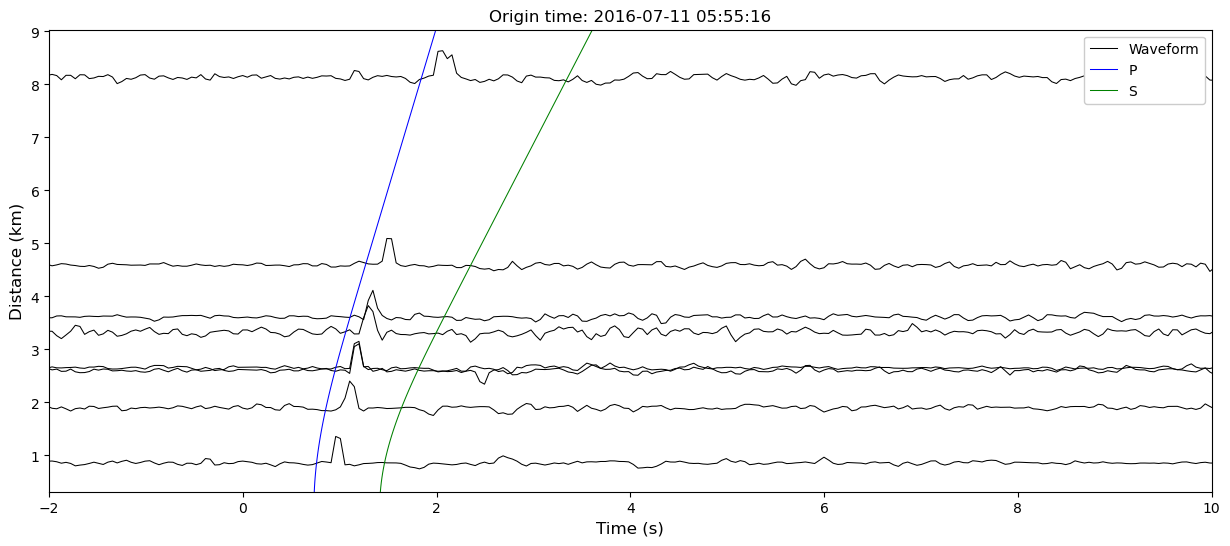

In [11]:
channel = "DPZ"

fig = ss.prs(st_dls.select(channel=channel),
             evt0, evlo, evla, evdp, scale=0.5, model_name=model_name,
             xmin=-2, xmax=10, width=15, height=6, handle=True)



## Prepare a travel time lookup table for P- and S-wave

In [12]:
#--- parameters for travel time calculation
min_dist_k, max_dist_k, step_dist_k = 0.0, 50.0, 2.0    # start, end and step for epicentral distance in km
min_dep_k, max_dep_k, step_dep_k = 0.0, 15.0, 0.5       # start, end and step for depth in km


In [13]:
#--- perform calculation for P-wave
phase = 'p'
mod_dist_r1, mod_dep_r1, mod_ttp_r2, computation_time = ss.prepare_traveltime_lookup_table(
    min_dist_k, max_dist_k, step_dist_k,
    min_dep_k, max_dep_k, step_dep_k,
    phase, model_name=model_name, dask_client=dask_client
)


In [14]:
#--- perform calculation for S-wave
phase = 's'
_, _, mod_tts_r2, computation_time = ss.prepare_traveltime_lookup_table(
    min_dist_k, max_dist_k, step_dist_k,
    min_dep_k, max_dep_k, step_dep_k,
    phase, model_name=model_name, dask_client=dask_client
)


## Backprojection

Define parameters for backprojection

In [15]:
#--- prepare source grid
min_lon, max_lon = -97.75, -97.59        # deg
min_lat, max_lat = 36.59, 36.64          # deg
min_dep, max_dep = 0, 15                 # km
step_x, step_y, step_z = 0.25, 0.25, 0.25  # km

#--- calculation of time window
w = 0.25 # window size in seconds
o = 0.80 # overlap fraction for successive window

#--- Positioon of the brightness value on the time window: 'start', 'mid' or 'end'
pos = 'mid'

#--- components for calculation
p_components = ['Z']
s_components = ['N', 'E']


Compute 4-D (time-space) brightness function

In [16]:
brightness4 = ss.do_bp(st_dls, dask_client, w,
            min_lon, max_lon, min_lat, max_lat, min_dep, max_dep, step_x, step_y, step_z,
            mod_dist_r1, mod_dep_r1, mod_ttp_r2, mod_tts_r2,
            o=o,
            pos=pos,
            p_components=p_components,
            s_components=s_components)

Get backprojected solution

In [17]:
evt0_bp, evlo_bp, evla_bp, evdp_bp = brightness4.get_solution()

print(f'Backprojected event origin time: {evt0_bp.strftime("%Y-%m-%d %H:%M:%S.%f")}')
print(f'Backprojected event longitude: {evlo_bp:0.04f} deg.')
print(f'Backprojected event latitude: {evla_bp:0.04f} deg.')
print(f'Backprojected event depth: {evdp_bp:0.02f} km.')

Backprojected event origin time: 2016-07-11 05:55:16.578000
Backprojected event longitude: -97.6913 deg.
Backprojected event latitude: 36.6170 deg.
Backprojected event depth: 2.75 km.


Difference between the backprojected and analyst solution

In [18]:
# Difference between backprojected and analyst origin time
evt0_diff = evt0_bp - evt0

# Distance between backprojected and analyst epicenter
dist_meter, _, _ = gps2dist_azimuth(evla, evlo, evla_bp, evlo_bp)
dist_km = dist_meter / 1000

# Difference between backprojected and analyst depth
depth_diff = evdp_bp - evdp

print(f'Difference between backprojected and analyst origin time: {evt0_diff:0.02f} seconds.')
print(f'Distance between backprojected and analyst epicenter: {dist_km:0.02f} km.')
print(f'Difference between backprojected and analyst depth: {depth_diff:0.02f} km.')

Difference between backprojected and analyst origin time: 0.19 seconds.
Distance between backprojected and analyst epicenter: 0.22 km.
Difference between backprojected and analyst depth: -0.25 km.


## Plot the results

Get reference station coordinates

In [19]:
station_list = sorted(list(set([tr.stats.station for tr in st_dls])))
stlo_list = [st_dls.select(station=station)[0].stats.sac.stlo for station in station_list]
stla_list = [st_dls.select(station=station)[0].stats.sac.stla for station in station_list]


Plot XY brightness slices at the backprojected source

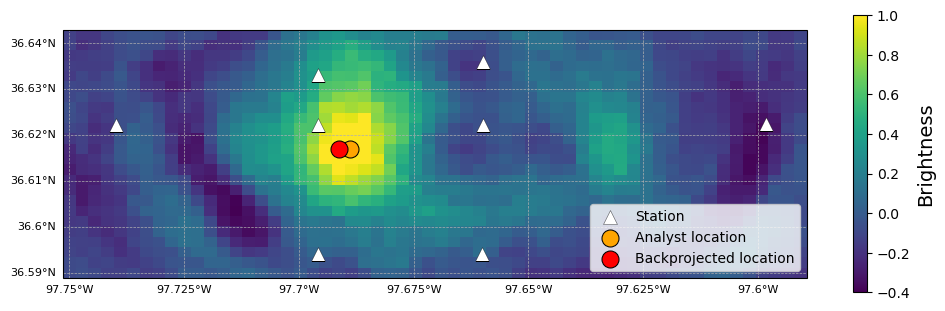

In [20]:
fig = plt.figure(figsize=(12,12))
projection = ccrs.PlateCarree()
ax = fig.add_subplot(projection=projection)

# axes gridlines and ticklabels
gl = ax.gridlines(ls='--', lw=0.5)
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = {'fontsize':8}
gl.ylabel_style = {'fontsize':8}

# Plot brightness
s = brightness4.plot_slice(ax, plane='xy', t=evt0_bp)
s.set_clim(vmin=-0.4, vmax=1.0)

cbar = fig.colorbar(s, shrink=0.3);
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('Brightness', fontsize=14)

# plot stations
ax.scatter(stlo_list, stla_list, marker='^', ec='k', fc='w', lw=0.25, s=100, label='Station')

# plot analyst event
ax.scatter(evlo, evla, marker='o', ec='k', fc='orange', lw=0.75, s=150, label='Analyst location')

# plot backprojected event
ax.scatter(evlo_bp, evla_bp, marker='o', ec='k', fc='red', lw=0.75, s=150, label='Backprojected location')

#--- legend
ax.legend(loc=4);

# fig.savefig(f'brightness_XY_slice.png', bbox_inches="tight")

Plot YZ brightness slices at the backprojected source

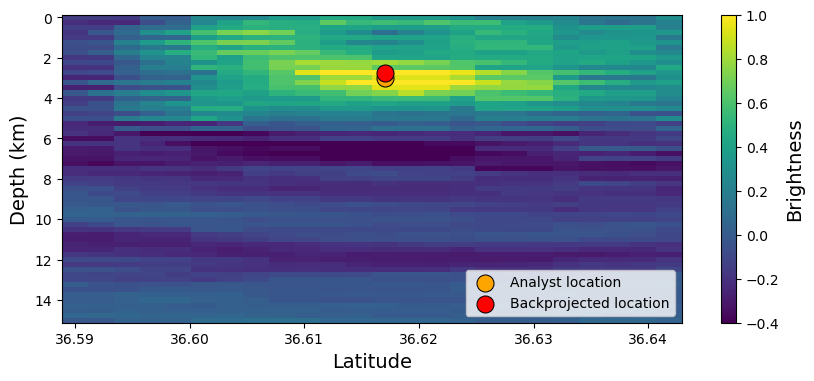

In [21]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()

ax.set_xlabel('Latitude', fontsize=14)
ax.set_ylabel('Depth (km)', fontsize=14);

#--- Plot brightness
s = brightness4.plot_slice(ax, plane='yz', t=evt0_bp)
s.set_clim(vmin=-0.4, vmax=1.0)

cbar = fig.colorbar(s, shrink=1.0);
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('Brightness', fontsize=14)

#--- plot analyst event
ax.scatter(evla, evdp, marker='o', ec='k', fc='orange', lw=0.75, s=150, label='Analyst location')

#--- plot backprojected event
ax.scatter(evla_bp, evdp_bp, marker='o', ec='k', fc='red', lw=0.75, s=150, label='Backprojected location')

#--- legend
ax.legend(loc=4);

# fig.savefig(f'brightness_YZ_slice.png', bbox_inches="tight")

Plot ZX brightness slices at the backprojected source

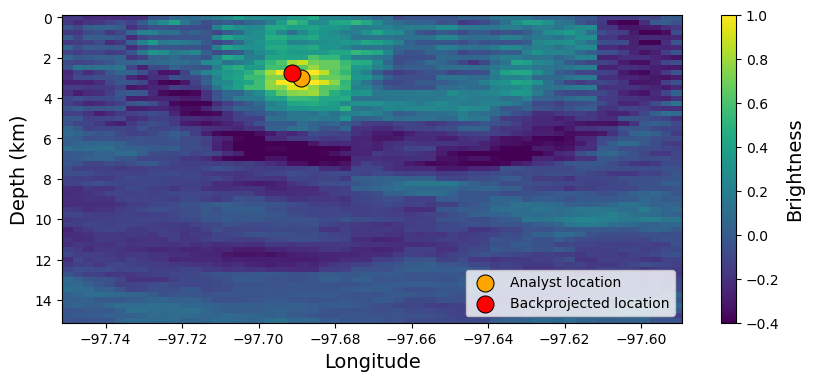

In [22]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Depth (km)', fontsize=14);

#--- Plot brightness
s = brightness4.plot_slice(ax, plane='zx', t=evt0_bp)
s.set_clim(vmin=-0.4, vmax=1.0)

cbar = fig.colorbar(s, shrink=1.0);
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('Brightness', fontsize=14)

# #--- plot analyst event
ax.scatter(evlo, evdp, marker='o', ec='k', fc='orange', lw=0.75, s=150, label='Analyst location')

# #--- plot backprojected event
ax.scatter(evlo_bp, evdp_bp, marker='o', ec='k', fc='red', lw=0.75, s=150, label='Backprojected location')

# #--- legend
ax.legend(loc=4);

# fig.savefig(f'brightness_ZX_slice.png', bbox_inches="tight")

get the backprojected stack

In [23]:
brightness_stack = brightness4.get_stack()
times = brightness_stack.get_times(reftime=evt0_bp)      # time of the stack
b_r1 = brightness_stack.b_r1                             # brightness of the stack

Plot the backprojected stack along with record section of the master station waveforms

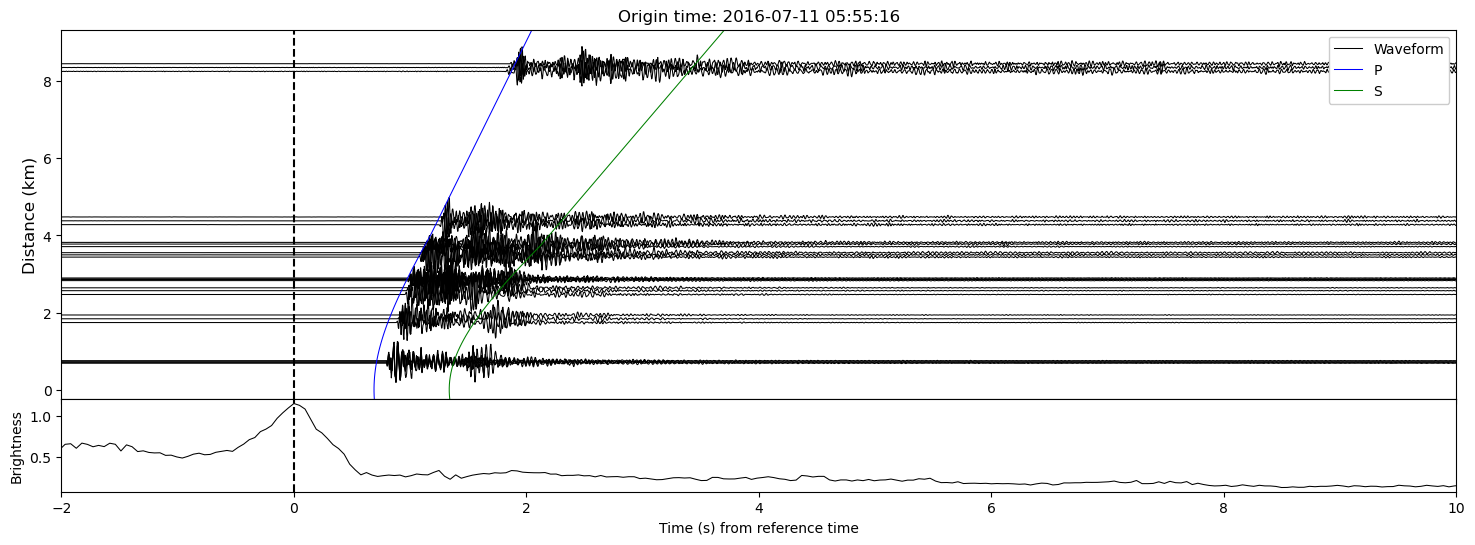

In [24]:
#--- Channel codes for this example are DPZ, DPN, DPE
channel = 'DPZ'

#--- create figure and axes
fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(5, hspace=0.0)
ax = fig.add_subplot(gs[0:4,0])
ax2 = fig.add_subplot(gs[4,0], sharex=ax)

ax2.set_ylabel('Brightness')
ax2.set_xlabel('Time (s) from reference time')

#--- remove xticklabels from ax
[label.set_visible(False) for label in ax.get_xticklabels()]

#--- plot record section of the reference waveforms
ss.prs(st_proc.select(channel=channel), evt0_bp, evlo_bp, evla_bp, evdp_bp, ax=ax, model_name=model_name, xmin=-2, xmax=10)
ax.axvline(0, color='k', ls='--')

# #--- plot stack
ax2.plot(times, b_r1, color='k', lw=0.75)
ax2.axvline(0, color='k', ls='--');

# fig.savefig(f'lsbp_stack_{channel}.png')

## Close DASK client

In [25]:
dask_client.close()
